<h1> 95% Consistency Analysis with Raw MBA Data </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

In [438]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [476]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> Helper Cleanup Functions </h3>

In [440]:
def dfNormalizer(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    total_boxes = df['total_boxes']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty, total_boxes=total_boxes))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

In [441]:
def removeTiersWithLimitedResults(df, limNum):
    df = df
    series= df['ispTech'].value_counts()
    limNum = limNum
    outList = []
    i = 0
    
    while i < len(series):
        for count in series:
            if count != limNum:
                outList.append(series.index[i])
            i+=1
            
    outDF = df[~df['ispTech'].isin(outList)]

    return outDF

<h3> SQL Queries

<h4> Validated dataset 2020 sql query

In [442]:
peak_download_val2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND
    queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
peak_download_val2020 = client.query(peak_download_val2020).to_dataframe()
print("executed")
print("validated dataset from Sep-Oct 2020")


executed
validated dataset from Sep-Oct 2020


<h4> Raw dataset December 2020 sql query

In [443]:
raw_download_dec2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_dec2020 = client.query(raw_download_dec2020).to_dataframe()
print("executed")
print("raw dataset from Dec 2020")


executed
raw dataset from Dec 2020


<h4> Raw dataset April 2021 sql query


In [444]:
raw_download_apr2021 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_apr2021 = client.query(raw_download_apr2021).to_dataframe()
print("executed")
print("raw dataset from Apr 2021")


executed
raw dataset from Apr 2021


In [445]:
# cleaning dfs
peak_download_val2020 = dfNormalizer(peak_download_val2020)
raw_download_dec2020 = dfNormalizer(raw_download_dec2020)
raw_download_apr2021 = dfNormalizer(raw_download_apr2021)

<h3> UDP Contiguous Loss Analaysis Queries </h3> 

In [446]:
udpcLossSQLVAL = """
SELECT 
    count(DISTINCT udploss.unit_id) as totalOutages, 
    mt.ISP as ISP, 
    mt.Technology as tech, 
    mt.Download as DownloadTier, 
    avg(udploss.duration/1000) as avgOutageMs, 
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMs,
    avg(udploss.packets) as avgPacketLoss, 
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
    COUNT(DISTINCT mt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_udpcloss` as udploss 
    INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON udploss.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM udploss.dtime) >= 19) AND (EXTRACT(HOUR FROM udploss.dtime) <=23) AND
            udploss.ddate < (CAST('2020-10-01' as DATE)) 
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING COUNT(DISTINCT mt.unit_id) > 29
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""
val2020UDPCLOSS = client.query(udpcLossSQLVAL).to_dataframe()
print("executed")
print("UPDC Loss validated dataset")

executed
UPDC Loss validated dataset


In [447]:
udpcLossSQLDEC2020 = """
SELECT 
    count(DISTINCT udploss.unit_id) as totalOutages, 
    mt.ISP as ISP, 
    mt.Technology as tech, 
    mt.Download as DownloadTier, 
    avg(udploss.duration/1000) as avgOutageMs, 
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMs,
    avg(udploss.packets) as avgPacketLoss, 
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
    COUNT(DISTINCT mt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_udpclossRawDec2020` as udploss 
    INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON udploss.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM udploss.dtime) >= 19) AND (EXTRACT(HOUR FROM udploss.dtime) <=23)
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING COUNT(DISTINCT mt.unit_id) > 29
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""
rawDec20UDPCLoss = client.query(udpcLossSQLDEC2020).to_dataframe()
print("executed")
print("UPDC Loss dec 2020 table")

executed
UPDC Loss dec 2020 table


In [448]:
udpcLossSQLAPR2021 = """
SELECT 
    count(DISTINCT udploss.unit_id) as totalOutages, 
    mt.ISP as ISP, 
    mt.Technology as tech, 
    mt.Download as DownloadTier, 
    avg(udploss.duration/1000) as avgOutageMs, 
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMs,
    APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMs,
    avg(udploss.packets) as avgPacketLoss, 
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
    APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
    COUNT(DISTINCT mt.unit_id) as total_boxes
FROM `broadband-data.mba_data.curr_udpclossRawApr2021` as udploss 
    INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON udploss.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM udploss.dtime) >= 19) AND (EXTRACT(HOUR FROM udploss.dtime) <=23)
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING COUNT(DISTINCT mt.unit_id) > 29
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""
rawApr21UDPCLoss = client.query(udpcLossSQLAPR2021).to_dataframe()
print("executed")
print("UPDC Loss Apr 2021 table")

executed
UPDC Loss Apr 2021 table


In [449]:
# cleaning sept/oct columns
val2020UDPCLoss.rename(columns={'DownloadTier': 'tier', 'ISP':'isp'}, inplace=True)
val2020UDPCLoss['month'] = 'Oct/Sep2020'
valCols = val2020UDPCLoss.columns.difference(peak_download_val2020.columns)


# cleaning dec columns
rawDec20UDPCLoss.rename(columns={'DownloadTier': 'tier', 'ISP':'isp'}, inplace=True)
rawDec20UDPCLoss['month'] = 'Dec2020'
decCols = rawDec20UDPCLoss.columns.difference(raw_download_dec2020.columns)


# cleaning dec columns
rawApr21UDPCLoss.rename(columns={'DownloadTier': 'tier', 'ISP':'isp'}, inplace=True)
rawApr21UDPCLoss['month'] = 'Apr2021'
aprCols = rawApr21UDPCLoss.columns.difference(raw_download_apr2021.columns)


In [450]:
valMBA2020 = pd.merge(peak_download_val2020, val2020UDPCLoss[valCols],left_index=True, 
                      right_index=True, how='outer').dropna()

rawMBADec20 = pd.merge(raw_download_dec2020, rawDec20UDPCLoss[decCols],left_index=True, 
                      right_index=True, how='outer').dropna()

rawMBAApr21 = pd.merge(raw_download_apr2021, rawApr21UDPCLoss[decCols],left_index=True, 
                      right_index=True, how='outer').dropna()

In [451]:
# creating final concat df
frames = [valMBA2020,rawMBADec20,rawMBAApr21]
finalMBADF = pd.concat(frames)
finalMBADF = removeTiersWithLimitedResults(finalMBADF, 3)
finalMBADF=finalMBADF.sort_values(by=['tier'])


In [452]:
dslDF = finalMBADF.where(finalMBADF.tech =='DSL').dropna() 

cableDF = finalMBADF.where(finalMBADF.tech =='Cable').dropna() 

fiberDF = finalMBADF.where(finalMBADF.tech =='Fiber').dropna() 


<h2> Charts & Analysis </h2>

Text(0.5, 1.0, "Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

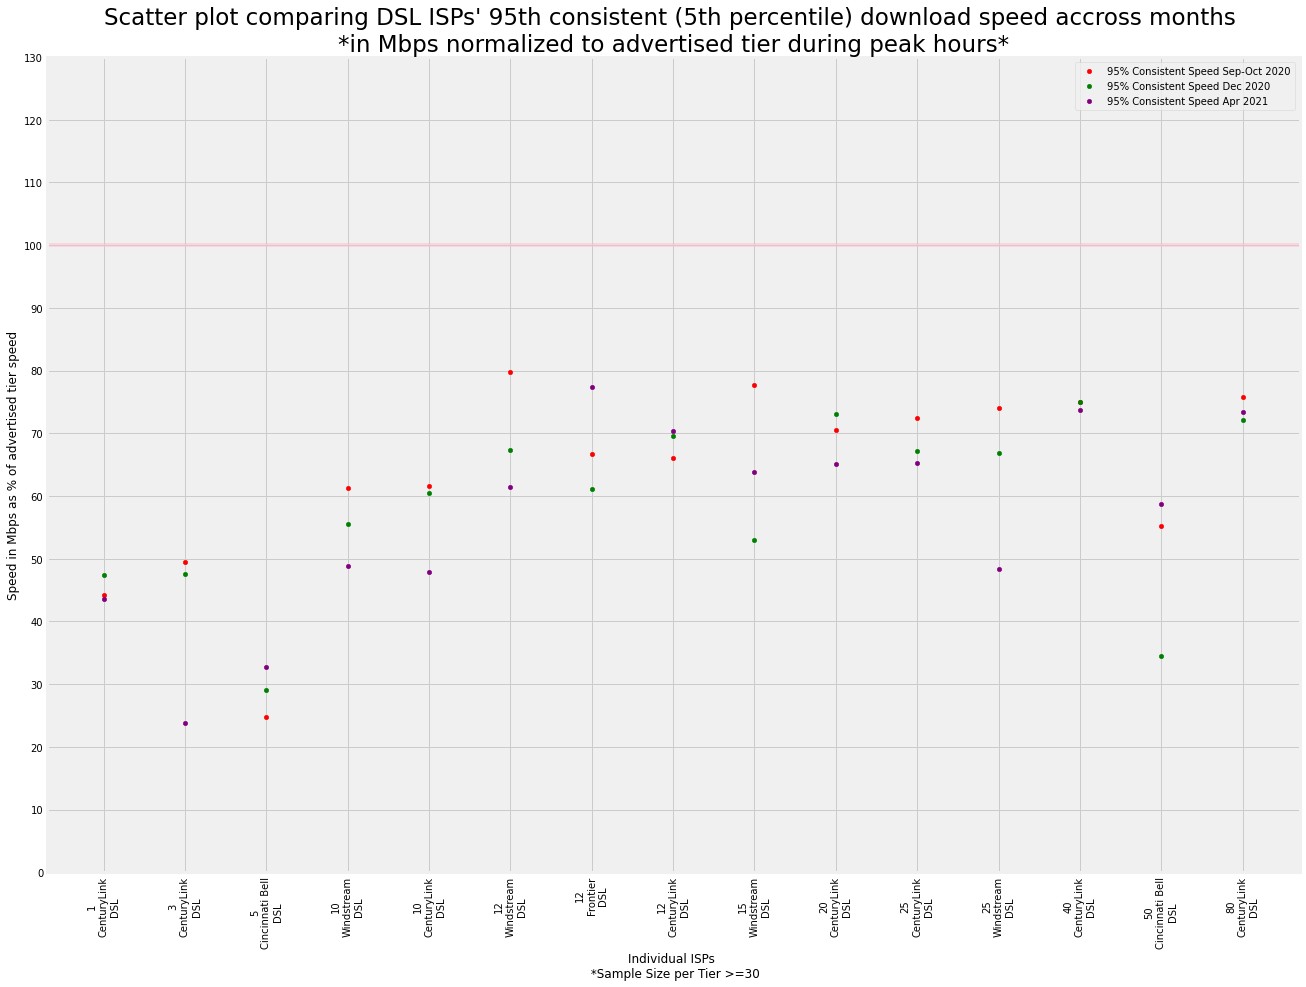

In [467]:
sep20DF = dslDF.where(dslDF.month =='Oct/Sep2020').dropna() 
dec20DF = dslDF.where(dslDF.month =='Dec2020').dropna() 
apr21DF = dslDF.where(dslDF.month =='Apr2021').dropna() 

plt.rcParams["figure.figsize"] = [20, 15]

ax1 = sep20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = dec20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = apr21DF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 140, 10))
plt.xticks(np.arange(0, len(dslDF)/3, 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

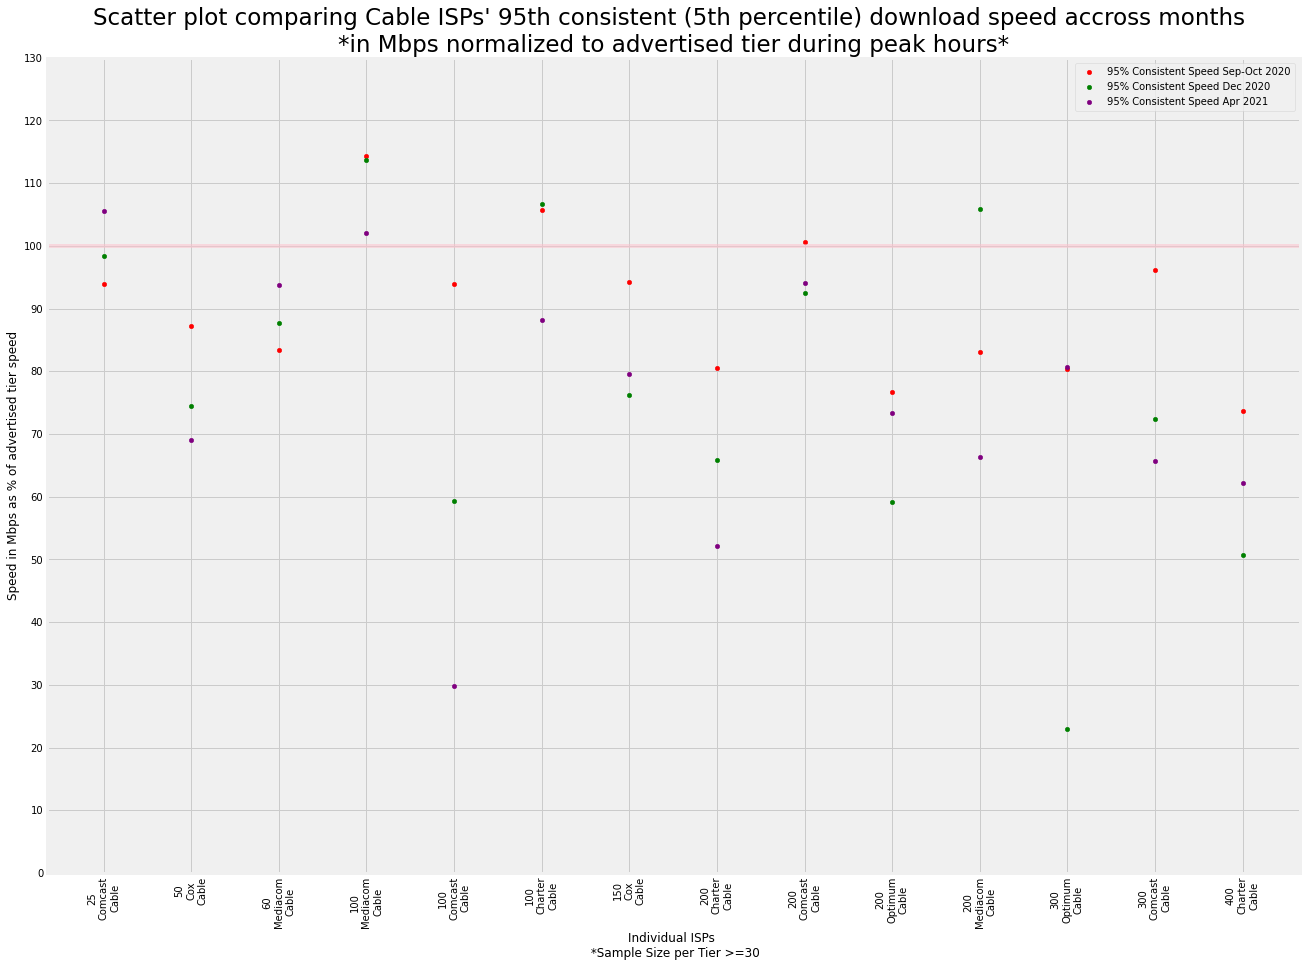

In [468]:
sep20DF = cableDF.where(cableDF.month =='Oct/Sep2020').dropna() 
dec20DF = cableDF.where(cableDF.month =='Dec2020').dropna() 
apr21DF = cableDF.where(cableDF.month =='Apr2021').dropna() 

plt.rcParams["figure.figsize"] = [20, 15]

ax1 = sep20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = dec20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = apr21DF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 140, 10))
plt.xticks(np.arange(0, len(cableDF)/3, 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

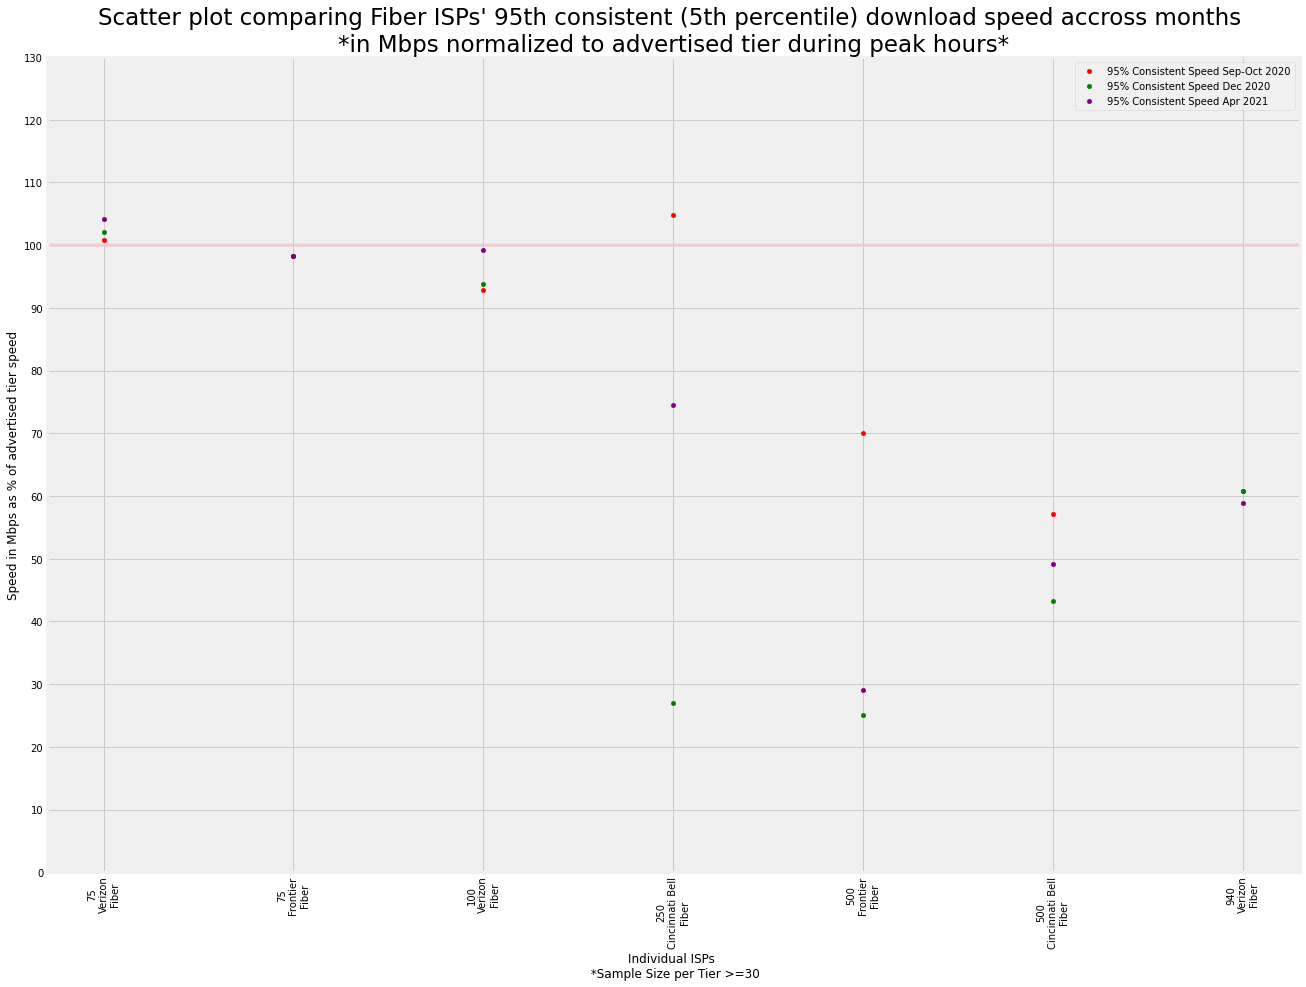

In [469]:
sep20DF = fiberDF.where(fiberDF.month =='Oct/Sep2020').dropna() 
dec20DF = fiberDF.where(fiberDF.month =='Dec2020').dropna() 
apr21DF = fiberDF.where(fiberDF.month =='Apr2021').dropna() 

plt.rcParams["figure.figsize"] = [20, 15]

ax1 = sep20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = dec20DF.plot(kind='scatter', x='ispTech', y='fivepct', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = apr21DF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 140, 10))
plt.xticks(np.arange(0, len(fiberDF)/3, 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


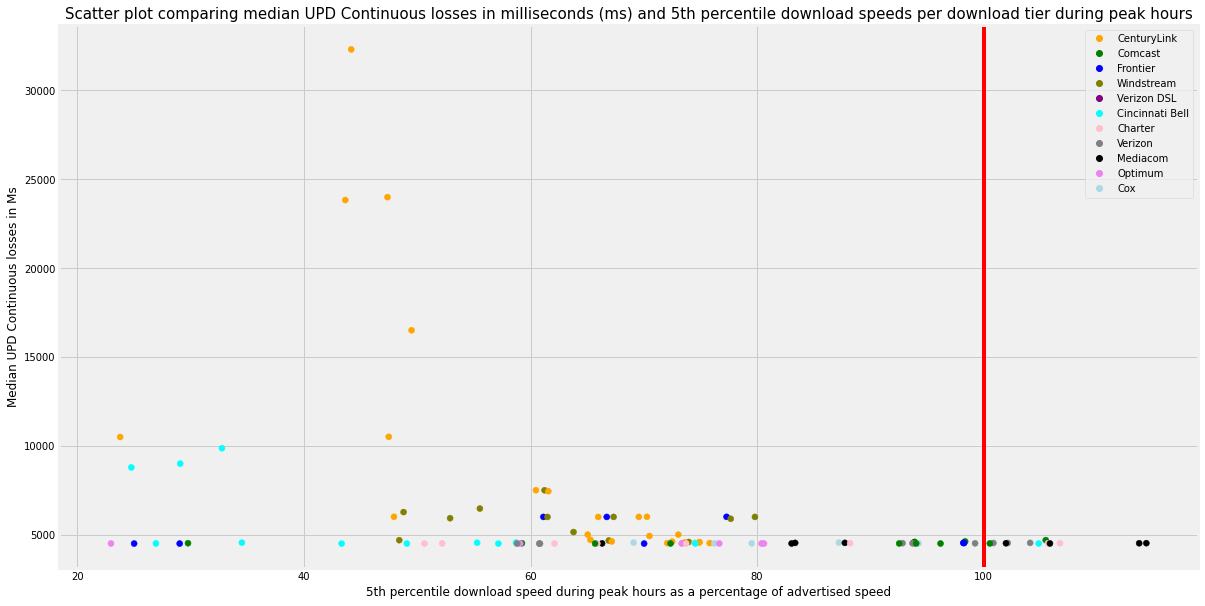

In [475]:
X =  finalMBADF['fivepct']
Y = finalMBADF.sort_values(by=['medianOutageMs'],ascending=False)['medianOutageMs']


fig = plt.figure()
plt.rcParams["figure.figsize"] = [40, 10]
ax1 = fig.add_subplot(122)


colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'olive',
        'Verizon DSL': 'purple', 'Cincinnati Bell': 'cyan', 'Charter': 'pink', 'Verizon': 'gray', 
        'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X, Y, c=finalMBADF['isp'].map(colors))
# ax1.scatter(X, Y)
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
# markers = [plt.Line2D([0,0],[0,0], marker='o', linestyle='')]
            
plt.legend(markers, colors, numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speed")
plt.ylabel("Median UPD Continuous losses in Ms")
plt.title("Scatter plot comparing median UPD Continuous losses in milliseconds (ms) and 5th percentile download speeds per download tier during peak hours",fontsize=15)

plt.show()

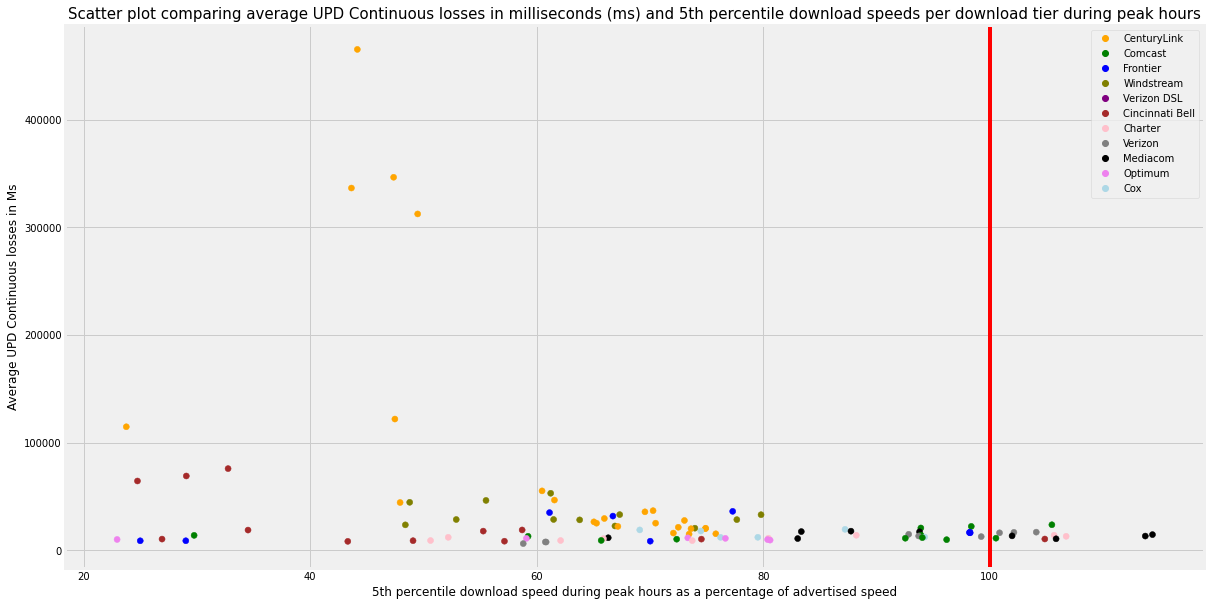

In [473]:
X =  finalMBADF['fivepct']
Y = finalMBADF.sort_values(by=['avgOutageMs'],ascending=False)['avgOutageMs']


fig = plt.figure()
plt.rcParams["figure.figsize"] = [40, 10]
ax1 = fig.add_subplot(122)


colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'olive',
        'Verizon DSL': 'purple', 'Cincinnati Bell': 'brown', 'Charter': 'pink', 'Verizon': 'gray', 
        'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X, Y, c=finalMBADF['isp'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
            
plt.legend(markers, colors, numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speed")
plt.ylabel("Average UPD Continuous losses in Ms")
plt.title("Scatter plot comparing average UPD Continuous losses in milliseconds (ms) and 5th percentile download speeds per download tier during peak hours",fontsize=15)

plt.show()

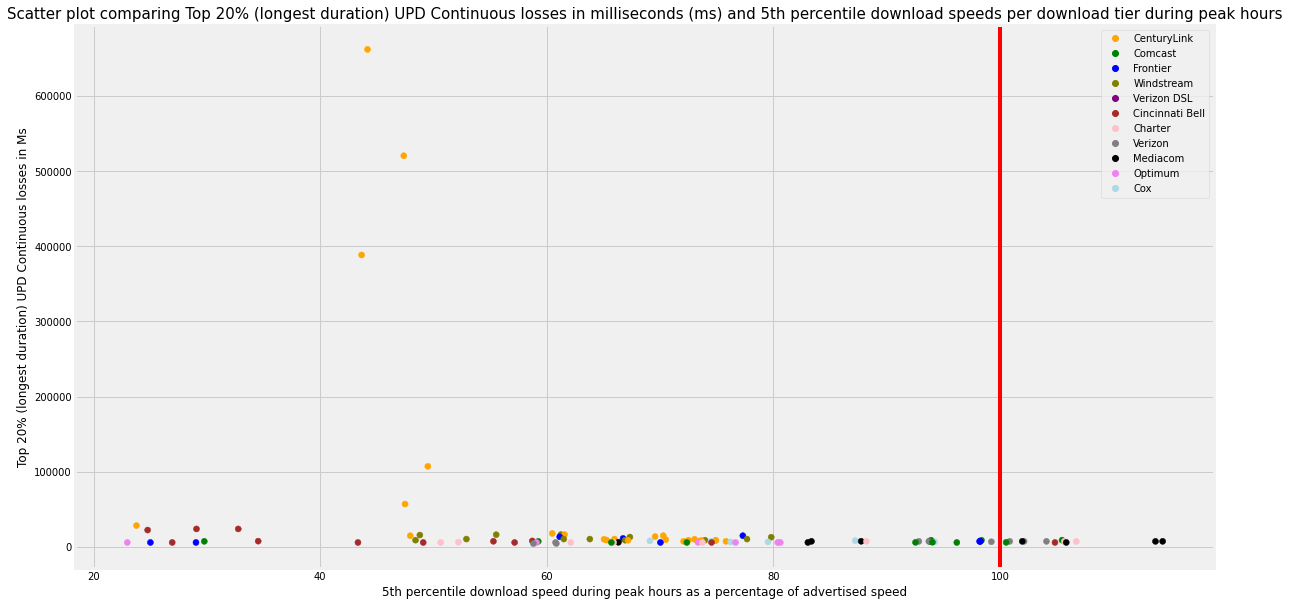

In [477]:
X =  finalMBADF['fivepct']
Y = finalMBADF.sort_values(by=['twentyPctOutageMs'],ascending=False)['twentyPctOutageMs']


fig = plt.figure()
plt.rcParams["figure.figsize"] = [40, 10]
ax1 = fig.add_subplot(122)


colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'olive',
        'Verizon DSL': 'purple', 'Cincinnati Bell': 'brown', 'Charter': 'pink', 'Verizon': 'gray', 
        'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X, Y, c=finalMBADF['isp'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
            
plt.legend(markers, colors, numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speed")
plt.ylabel("Top 20% (longest duration) UPD Continuous losses in Ms")
plt.title("Scatter plot comparing Top 20% (longest duration) UPD Continuous losses in milliseconds (ms) and 5th percentile download speeds per download tier during peak hours",fontsize=15)

plt.show()